# Customer Age Determination

The goal of any business is to make a profit.
Depending on the type of business, various factors can affect profits, especially when it comes to retail. Supermarkets actively attract customers using marketing techniques. Machine learning also helps with this.
By studying and profiling customers, the seller can actively offer them exactly those products that are of interest of each individual category, therefore, the chances of maximizing profits increase.

'Bread&Salt' supermarket chain introduces a computer vision system for processing customers' photos. Photo fixation in the checkout area will help determine the age of customers in order to:
1) analyze purchases and offer products that may be of interest to buyers of this age group;

2) control the conscientiousness of cashiers when selling alcohol.

**The purpose of this study** is to build a model that will determine the approximate age of a person from a photograph.
To achieve this goal, we have at our disposal one folder with images (/final_files) and a csv file labels.csv with two columns: file_name (file name) and real_age (real age), that is, our target feature.

**Research Progress**

We will predict the age from images using a neural network, choosing its optimal architecture and parameters for a given dataset. We will evaluate the quality of predictions with the help of the mean absolute error, that is, MAE, the values of which should not exceed 7.

Thus, this project will include the following steps:
* exploratory data analysis
* building a neural network model and fitting it
* assessment of the quality of the model

## Data Discovery

In [1]:
import numpy as np  # importing numpy
import pandas as pd  # importing pandas
import seaborn as sns # importing seaborn for plotting
import matplotlib.pyplot as plt  # importing matplotlib for plotting
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator # importing ImageDataGenerator for loading images
from PIL import Image # importing Image for visualyzing images
import matplotlib.image as mpimg # importing mpimg for visualyzing images

First of all, let's download the data to analyze:

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv') # reading a csv file to df
# creating a loader, passing all necessary parameters
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Let's start analyzing the dataframe. First of all, we visualize its several objects:

In [3]:
labels.head() # getting 5 first df objects

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


So, there are two features in the dataframe: the name of the file and the age of the person depicted on it, that is, our target feature.
Next, we will visualize general information about the table:

In [4]:
labels.info() # getting general info on the df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Based on the obtained information, it can be concluded that the type of data in both columns corresponds to the nature of the feature. In addition, there are no missing values in the dataset.
Let's check if there are full duplicates in it:

In [5]:
labels.duplicated().sum() # checking the df for full duplicates


0

So, there are no full duplicates, each table object is unique, which means it is useful for fitting  a future model. In addition, from the information obtained earlier, we can conclude that there are quite a lot of images - more than 7500: we will take this into account when choosing the architecture of the neural network.

Next, we examine our target feature in more detail. First of all, let's look at its distribution using a histogram:

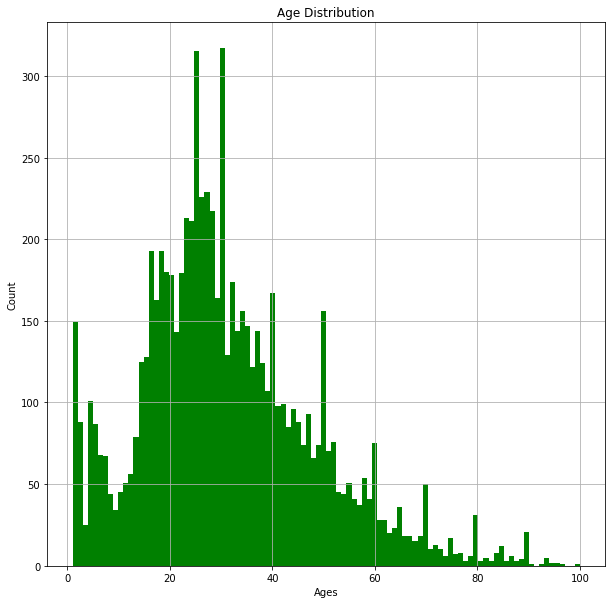

In [6]:
ax = labels.hist(['real_age'], bins=100, figsize=(10,10), facecolor='g'); # plotting histogram
plt.ylabel("Count") # setting the name for  y axis
plt.xlabel("Ages") # setting the name for  x axis
plt.title('Age Distribution'); # setting the title

So, the distribution of the target feature is quite normal with some skew to the right. Most of the people shown in the photo belong to the category from 25 to 35 years old, we observe a fairly large number of children from 1 year old. In addition, the folder contains photographs of older people, reaching 90 years and above, but they are few. The presence of images with people of different age categories will undoubtedly help to fit the network in the best possible way.

Next, using the describe() method, we check if our visual analysis is true:

In [7]:
labels.describe() # visualyzing df stats

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


The obtained data is consistent with visualization using a histogram. We can see that the mean and median (approx. 31 and 29 years) are not far from each other, which also indicates that this distribution is close to normal.
Next, using the "box with a mustache" check the dataframe for anomalous values:

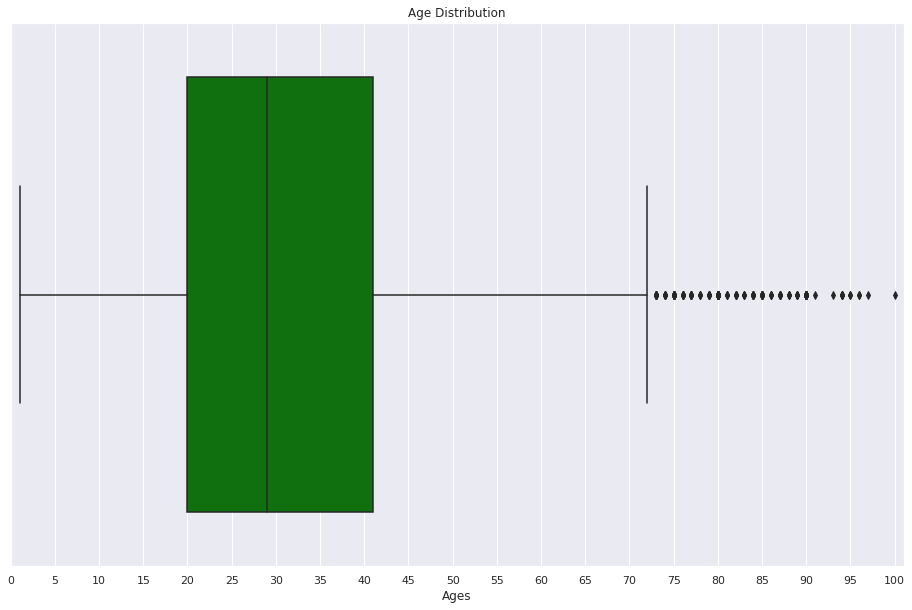

In [8]:
sns.set(rc = {'figure.figsize':(16, 10)}) # setting the size
ax = sns.boxplot(data=labels, x='real_age', color='green') # plotting the boxplot
ax.set_xticks(range(0, 101, 5))  # setting the tange for x axis 
ax.set_xticklabels(range(0,101, 5))  # setting the ticks for x axis
plt.xlim([0,101]);  # setting min and max for x axis
ax.set_xlabel("Ages") # setting the name of x axis
ax.set_title('Age Distribution'); # setting the title

Our task is to predict the age from a photograph, therefore, we are faced with a regression problem. At the same time, we know that linear regression is quite sensitive to outliers.
As for our dataframe, on the right we see several outliers that lie outside the 1.5 interquartile ranges. Nevertheless, we cannot categorize them as true outliers or, moreover, errors, therefore, we will not clear the dataframe from them.

Next, in accordance with the task, we will print the first 16 images on the screen:

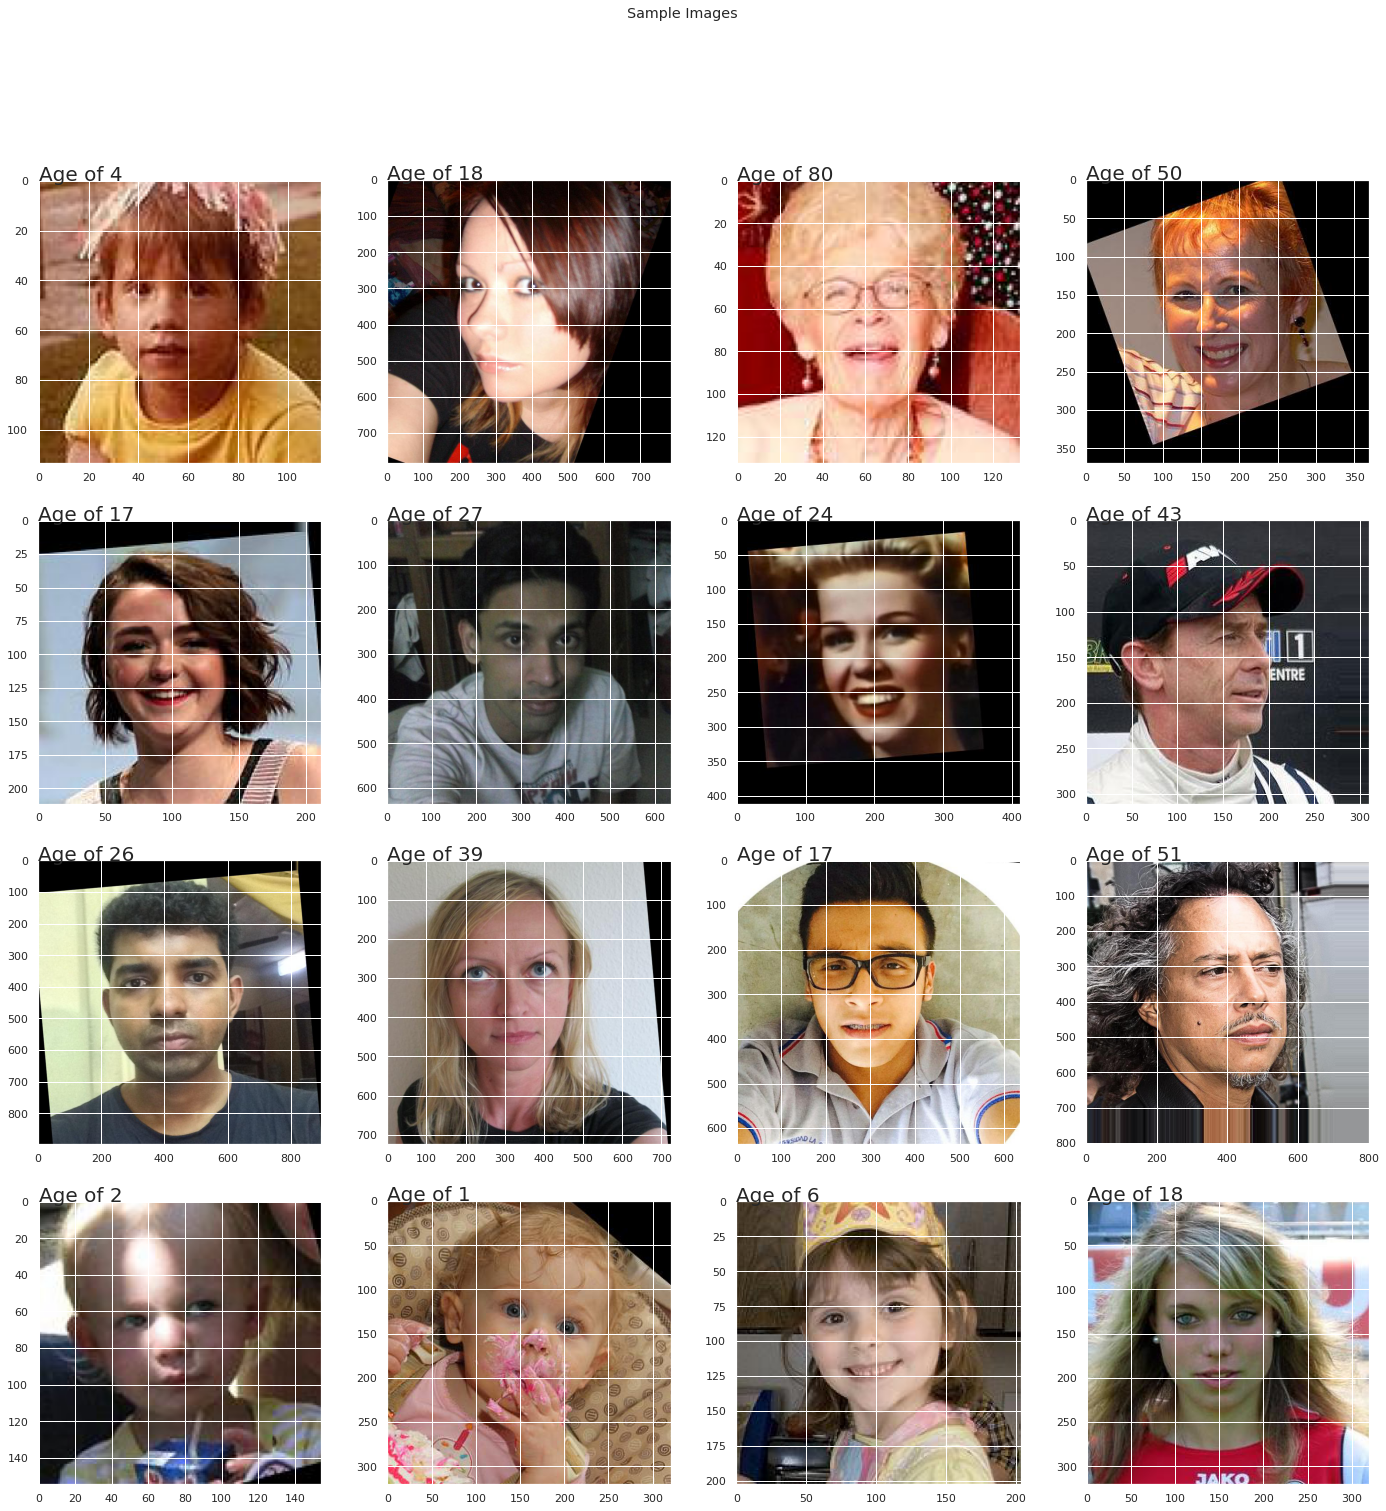

In [9]:
# visualizing some of images present in the folder:
fig = plt.figure(figsize=(24, 24)) 
for i in range(16):
    plt.subplot(4,4,i+1)   
    img = mpimg.imread(f'/datasets/faces/final_files/{labels["file_name"][i]}')
    plt.imshow(img)
    plt.text(0, 0, f'Age of {labels["real_age"][i]}', fontsize=20)
 
    
fig.suptitle('Sample Images')
plt.show()

The quality, type, as well as the size of the photos are quite different. On the presented 16 pictures there are different light gamuts, the values along the axes allow us to understand that the sizes of the images differ by several times (for example, 100 and 700), some images are rotated relative to the axis, not all of the photographs have people taken in full face. At the next stage of the study, we will try to unify them somewhat.

**Conclusions** So, based on the results of the data discovery, we can conclude that the data are of high quality, but require transformations, which means that they are useful for learning, as well as their volume - we will take it into account when setting up the architecture of the neural network.
Next, we proceed directly to its creating and fitting.

## Creating and Fitting a Model

So, according to the task, we need to define 4 separate functions: for loading the train sample, test sample, creating and fitting the model.

As for the first two, we used the ImageDataGenerator loader, passing the parameters of the target image size, batch size, sampling ratio. In the case of the training sample, in order to increase the amount of data for training, we also added some augmentation parameters empirically. Our previous experience has shown that augmentation does not always improve a given metric, sometimes its presence is counterproductive. In this particular case, the horizontal flip helped to reduce the MAE somewhat.

As for the function that creates the model, the ResNet50 architecture was chosen, initially trained on 'imagenet', excluding its last two layers, without partially freezing ResNet50, since the training sample contained a sufficient number of elements. As the last layers of the model, we added pooling for averaging information and the last fully connected layer with one neuron (performing the regression task), where the activation function is the most efficient ReLu. The Adam algorithm, which is more beneficial for the neural network with respect to gradient descent, was chosen as an optimizer with a lower learning rate relative to the default, and the mean square error was standardly chosen as the loss function.

The function for training the model is performed as standard. Empirically, the optimal number of epochs was chosen - 10.

```python

# importing necessary libraries


import numpy as np
import pandas as pd
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50


# defining a function to load train sample


def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, 
                                    validation_split=0.25)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345) 
    return train_gen_flow


# defining a function to load test sample


def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 
    return test_gen_flow


# defining a function to create a model


def create_model(input_shape):
    optimizer = Adam(lr=0.0001) 
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1,  activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
 
    return model


#  defining a function to fit the model


def train_model(model, train_data, test_data, batch_size = None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
          validation_data=test_data, batch_size=batch_size, epochs=epochs, steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model


```

```
178/178 - 150s - loss: 263.6192 - mae: 11.8810 - val_loss: 832.3905 - val_mae: 23.9560
Epoch 2/10
178/178 - 39s - loss: 102.8127 - mae: 7.6215 - val_loss: 793.9350 - val_mae: 23.2265
Epoch 3/10
178/178 - 38s - loss: 79.8019 - mae: 6.7512 - val_loss: 315.9998 - val_mae: 13.1598
Epoch 4/10
178/178 - 38s - loss: 62.0177 - mae: 6.0031 - val_loss: 129.2678 - val_mae: 8.6415
Epoch 5/10
178/178 - 38s - loss: 52.5053 - mae: 5.4723 - val_loss: 100.6334 - val_mae: 7.3452
Epoch 6/10
178/178 - 38s - loss: 44.9820 - mae: 5.0628 - val_loss: 81.4905 - val_mae: 6.7439
Epoch 7/10
178/178 - 38s - loss: 38.5365 - mae: 4.6916 - val_loss: 89.7203 - val_mae: 6.9891
Epoch 8/10
178/178 - 38s - loss: 33.3673 - mae: 4.4118 - val_loss: 71.9713 - val_mae: 6.2140
Epoch 9/10
178/178 - 38s - loss: 28.5182 - mae: 4.0496 - val_loss: 77.0551 - val_mae: 6.6224
Epoch 10/10
178/178 - 38s - loss: 25.0925 - mae: 3.8139 - val_loss: 69.9409 - val_mae: 6.2119

```

## Fit Model Analysis

So, empirically, we managed to build and fit a model that, on the test sample on this particular dataset, reached the metric value that exceeded the target one - approx. 6.2. The goal has been reached.

## Study Results

In the course of this study, we downloaded and studied the submitted data: images and a dataframe that includes the names of the images, indicating the age, that is, our target feature.
These data, the quality and volume of which seemed to be satisfactory, were used to fit a neural network model based on the ResNet50 architecture. Empirically, the optimal composition and network parameters were chosen, which made it possible to exceed the MAE target  (approx. 6.2 vs. 7).
From the point of view of the needs of the customer, given the error value, we can conclude that we have coped with the task, therefore, in the vast majority of cases, the system will correctly determine the age of buyers and recommend them popular products for this age category, for which, perhaps, they themselves they wouldn't pay attention. An increase in turnover leads to an increase in profits (ceteris paribus).
From the point of view of the experience gained, however, this model is not universal, it would probably show different results on a different dataset. 